✅ Phase 1: Setup – Step 1: Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
import zipfile
import os

In [5]:
rainy_dir = '/content/drive/MyDrive/Rainy_road_images'
road_dir = '/content/drive/MyDrive/Road_images'


✅ Phase 2: Load Image File Paths – Step 1: Gather Rainy and Road Image File Paths

In [7]:
import os

rainy_files = sorted([os.path.join(rainy_dir, f) for f in os.listdir(rainy_dir) if f.endswith(".jpg") or f.endswith(".png")])
road_files = sorted([os.path.join(road_dir, f) for f in os.listdir(road_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Fix length mismatch by taking the minimum length
min_len = min(len(rainy_files), len(road_files))
rainy_files = rainy_files[:min_len]
road_files = road_files[:min_len]

print(f"✅ Using {min_len} image pairs for training.")


✅ Using 554 image pairs for training.


✅ Phase 3: Image Loading and Preprocessing – Step 2

In [55]:
import tensorflow as tf

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # normalize to [-1,1]
    return image

def load_and_preprocess(rainy_path, road_path):
    rainy_image = load_image(rainy_path)
    road_image = load_image(road_path)
    return rainy_image, road_image

dataset = tf.data.Dataset.from_tensor_slices((rainy_files, road_files))
dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(1).prefetch(tf.data.AUTOTUNE)


✅ Phase 4: Model Architecture – Generator & Discriminator

In [ ]:
from tensorflow.keras import layers

def build_generator():
    inputs = layers.Input(shape=[256,256,3])
    # A minimal U-Net style or any Pix2Pix generator architecture here
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    inp = layers.Input(shape=[256,256,3], name='input_image')
    tar = layers.Input(shape=[256,256,3], name='target_image')
    x = layers.concatenate([inp, tar])
    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

generator = build_generator()
discriminator = build_discriminator()


✅ Phase 5: Loss Functions, Optimizers, and Checkpointing

In [57]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Checkpointing
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = tf.train.Checkpoint(generator=generator,
                                 discriminator=discriminator,
                                 gen_optimizer=generator_optimizer,
                                 disc_optimizer=discriminator_optimizer)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")


✅ Phase 6: Training Loop — Pix2Pix (Rainy → Road)

In [58]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [59]:
def train(dataset, epochs, start_epoch=0):
    for epoch in range(start_epoch, epochs):
        print(f'🔁 Epoch {epoch+1}/{epochs}')
        for input_image, target in dataset:
            gen_loss, disc_loss = train_step(input_image, target)

        print(f'📉 Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}')

        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"✅ Checkpoint saved at epoch {epoch+1}")
            with open(os.path.join(checkpoint_dir, 'last_epoch.txt'), 'w') as f:
                f.write(str(epoch + 1))

    print("🏁 Training complete.")
    generator.save("pix2pix_generator_rainy2road_final.h5")
    print("✅ Model saved as pix2pix_generator_rainy2road_final.h5")


In [60]:
start_epoch = 0
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("✅ Checkpoint restored!")

    epoch_file = os.path.join(checkpoint_dir, 'last_epoch.txt')
    if os.path.exists(epoch_file):
        with open(epoch_file, 'r') as f:
            start_epoch = int(f.read())
        print(f"🔁 Resuming training from epoch {start_epoch + 1}")
    else:
        print("⚠️ 'last_epoch.txt' not found, resuming from checkpoint weights only.")
else:
    print("🆕 No checkpoint found. Starting training from scratch.")


🆕 No checkpoint found. Starting training from scratch.


In [14]:
import matplotlib.pyplot as plt


✅ PHASE 10 – Start Training

In [61]:
gen_losses = []
disc_losses = []



def train(dataset, epochs, start_epoch=0):
    gen_losses = []
    disc_losses = []

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🔁 Epoch {epoch + 1}/{start_epoch + epochs}")
        step_gen_losses = []
        step_disc_losses = []

        for step, (input_image, target) in enumerate(dataset):
            gen_loss, disc_loss = train_step(input_image, target)
            step_gen_losses.append(gen_loss.numpy())
            step_disc_losses.append(disc_loss.numpy())

        # Average loss per epoch
        avg_gen_loss = sum(step_gen_losses) / len(step_gen_losses)
        avg_disc_loss = sum(step_disc_losses) / len(step_disc_losses)

        print(f"📉 Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

    return {'gen_loss': gen_losses, 'disc_loss': disc_losses}

In [ ]:
EPOCHS = 100
history = train(dataset, EPOCHS, start_epoch=start_epoch)



🔁 Epoch 1/100
📉 Generator Loss: 40.2185, Discriminator Loss: 0.7864

🔁 Epoch 2/100
📉 Generator Loss: 23.5895, Discriminator Loss: 1.2722

🔁 Epoch 3/100
📉 Generator Loss: 18.3523, Discriminator Loss: 1.3171

🔁 Epoch 4/100
📉 Generator Loss: 17.6164, Discriminator Loss: 1.3002

🔁 Epoch 5/100
📉 Generator Loss: 17.0550, Discriminator Loss: 1.3162

🔁 Epoch 6/100
📉 Generator Loss: 16.7313, Discriminator Loss: 1.3219

🔁 Epoch 7/100
📉 Generator Loss: 16.6162, Discriminator Loss: 1.3228

🔁 Epoch 8/100
📉 Generator Loss: 16.3460, Discriminator Loss: 1.3238

🔁 Epoch 9/100
📉 Generator Loss: 16.2756, Discriminator Loss: 1.3157

🔁 Epoch 10/100
📉 Generator Loss: 16.1885, Discriminator Loss: 1.3069

🔁 Epoch 11/100
📉 Generator Loss: 16.0207, Discriminator Loss: 1.2926

🔁 Epoch 12/100
📉 Generator Loss: 16.0687, Discriminator Loss: 1.2776

🔁 Epoch 13/100
📉 Generator Loss: 15.8084, Discriminator Loss: 1.2594

🔁 Epoch 14/100
📉 Generator Loss: 15.7874, Discriminator Loss: 1.2371

🔁 Epoch 15/100
📉 Generator L

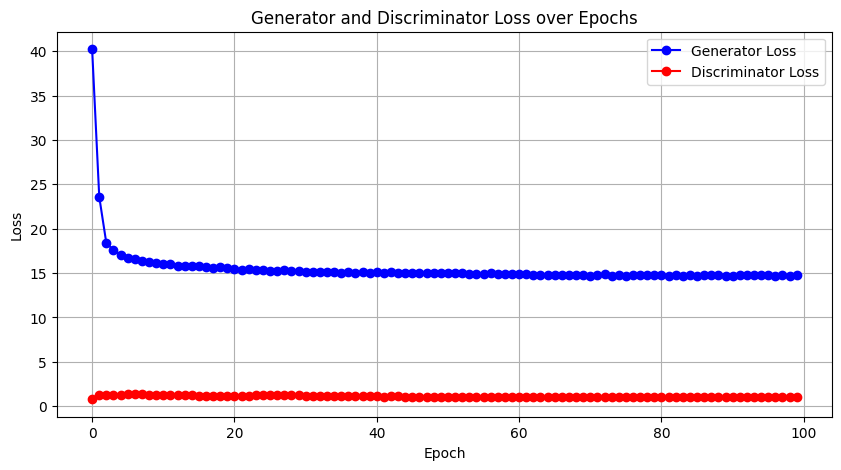

In [17]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['gen_loss'], label='Generator Loss', color='blue', marker='o')
plt.plot(history['disc_loss'], label='Discriminator Loss', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
generator.save("/content/drive/MyDrive/pix2pix_generator_100epochs.keras")
print("Model saved successfully!")


Model saved successfully!


In [ ]:


def dehaze_and_show_rainy_with_ground_truth(rainy_path, true_clear_path):
    # Load and preprocess Rainy Road image
    rainy_img = tf.io.read_file(rainy_path)
    rainy_img = tf.image.decode_jpeg(rainy_img)
    rainy_img = tf.image.resize(rainy_img, [256, 256])
    rainy_img = tf.cast(rainy_img, tf.float32) / 127.5 - 1
    input_img = tf.expand_dims(rainy_img, axis=0)

    # Predict Clear image using generator
    dehazed_img = generator(input_img, training=False)[0]
    dehazed_img = (dehazed_img + 1) / 2  # Rescale to [0, 1]

    # Load and preprocess True Clear Road image
    clear_img = tf.io.read_file(true_clear_path)
    clear_img = tf.image.decode_jpeg(clear_img)
    clear_img = tf.image.resize(clear_img, [256, 256])
    clear_img = tf.cast(clear_img, tf.float32) / 255.0  # Rescale to [0, 1]

    # Plot all three
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow((rainy_img + 1) / 2)
    plt.title("Rainy Road Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(dehazed_img)
    plt.title("Predicted Clear Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(clear_img)
    plt.title("True Clear Image")
    plt.axis("off")

    plt.show()


In [20]:
import os

test_folder = "/content/drive/MyDrive/Rainy_road_images"
print("Directory exists:", os.path.exists(test_folder))
print("Files in test folder:", os.listdir(test_folder))


Directory exists: True
Files in test folder: ['rainy_DL_168.jpg', 'rainy_DL_149.jpg', 'rainy_DL_36.jpg', 'rainy_DL_155.jpg', 'rainy_DL_0.jpg', 'rainy_DL_29.jpg', 'rainy_DL_37.jpg', 'rainy_DL_166.jpg', 'rainy_DL_126.jpg', 'rainy_DL_131.jpg', 'rainy_DL_28.jpg', 'rainy_DL_164.jpg', 'rainy_DL_15.jpg', 'rainy_DL_146.jpg', 'rainy_DL_34.jpg', 'rainy_DL_160.jpg', 'rainy_DL_4.jpg', 'rainy_DL_17.jpg', 'rainy_DL_14.jpg', 'rainy_DL_161.jpg', 'rainy_DL_18.jpg', 'rainy_DL_122.jpg', 'rainy_DL_3.jpg', 'rainy_DL_35.jpg', 'rainy_DL_170.jpg', 'rainy_DL_100.jpg', 'rainy_DL_152.jpg', 'rainy_DL_136.jpg', 'rainy_DL_42.jpg', 'rainy_DL_103.jpg', 'rainy_DL_116.jpg', 'rainy_DL_30.jpg', 'rainy_DL_1.jpg', 'rainy_DL_114.jpg', 'rainy_DL_157.jpg', 'rainy_DL_120.jpg', 'rainy_DL_123.jpg', 'rainy_DL_125.jpg', 'rainy_DL_16.jpg', 'rainy_DL_24.jpg', 'rainy_DL_132.jpg', 'rainy_DL_144.jpg', 'rainy_DL_129.jpg', 'rainy_DL_106.jpg', 'rainy_DL_22.jpg', 'rainy_DL_141.jpg', 'rainy_DL_20.jpg', 'rainy_DL_135.jpg', 'rainy_DL_147.jpg'


▶️ Processing: rainy_DL_0.jpg ↔ DL_0.jpg


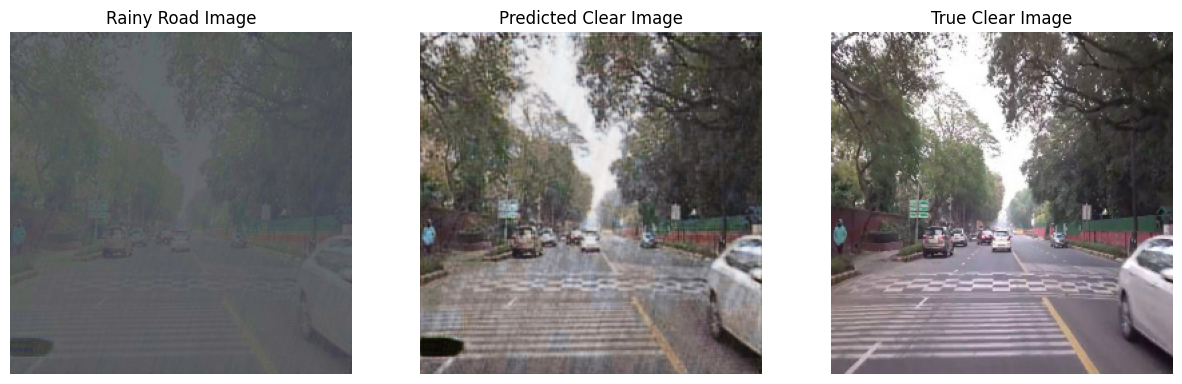


▶️ Processing: rainy_DL_1.jpg ↔ DL_1.jpg


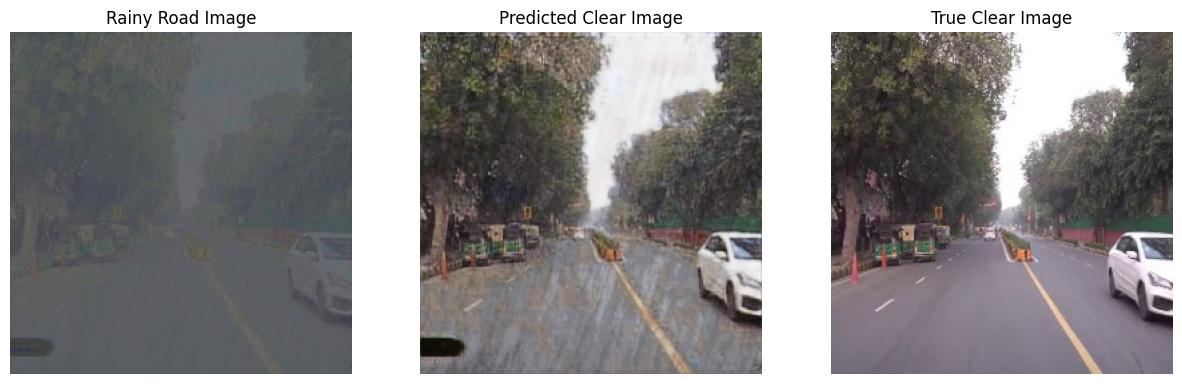


▶️ Processing: rainy_DL_10.jpg ↔ DL_10.jpg


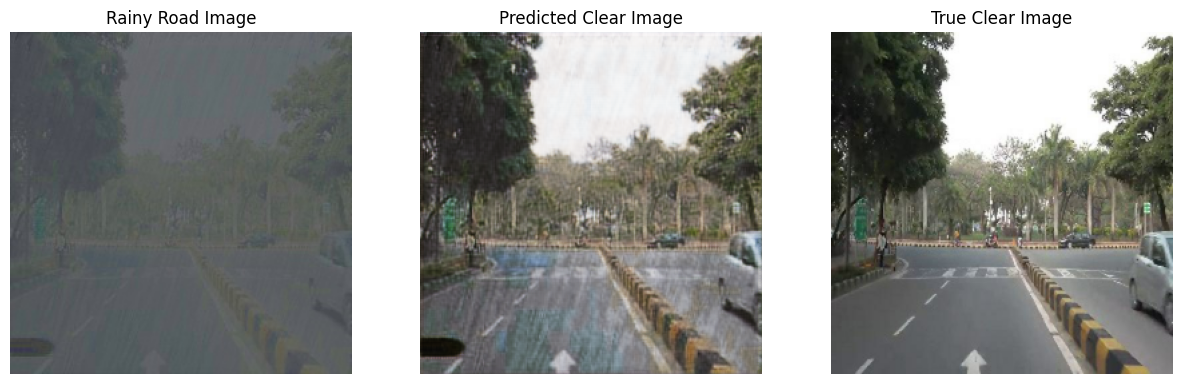

In [ ]:

# 2. Setting folder paths
rainy_folder = "/content/drive/MyDrive/Rainy_road_images"
clear_folder = "/content/drive/MyDrive/Road_images"

# 3. Getting filenames from both folders
rainy_files = sorted(os.listdir(rainy_folder))
clear_files = sorted(os.listdir(clear_folder))

# 4. Match and visualize a few (you can loop through more if needed)
for i in range(min(3, len(rainy_files), len(clear_files))):  # Show 5 samples max
    rainy_path = os.path.join(rainy_folder, rainy_files[i])
    clear_path = os.path.join(clear_folder, clear_files[i])

    print(f"\n▶️ Processing: {rainy_files[i]} ↔ {clear_files[i]}")
    dehaze_and_show_rainy_with_ground_truth(rainy_path, clear_path)

In [22]:
test_image_paths = [
    "/content/drive/MyDrive/Rainy_road_images/rainy_DL_11.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_DL_42.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_DL_13.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_DL_39.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_GHY_143.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_GHY_138.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_GHY_125.jpg",
    "/content/drive/MyDrive/Rainy_road_images/rainy_GHY_245.jpg",
]


In [23]:
!ls "/content/drive/MyDrive/pix2pix_generator_100epochs.keras"

/content/drive/MyDrive/pix2pix_generator_100epochs.keras


In [62]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Your image folder and output directory
test_dir = "/content/drive/MyDrive/Rainy_road_images"
output_dir = "/content/drive/MyDrive/my_model/output_file"
os.makedirs(output_dir, exist_ok=True)

# Load and normalize image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # normalize to [-1, 1]
    return image

# Generate and save output
def dehaze_and_save(image_path, model):
    image = load_image(image_path)
    image = tf.expand_dims(image, 0)  # add batch dimension
    prediction = model(image, training=False)[0]
    prediction = (prediction + 1) * 127.5  # convert back to [0, 255]
    prediction = tf.cast(prediction, tf.uint8).numpy()

    file_name = os.path.basename(image_path)
    save_path = os.path.join(output_dir, "dehazed_" + file_name)
    Image.fromarray(prediction).save(save_path)
    print(f"✅ Saved: {save_path}")

# List all test images
test_images = [
    os.path.join(test_dir, f)
    for f in os.listdir(test_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Load trained generator
generator = tf.keras.models.load_model(
    "/content/drive/MyDrive/pix2pix_generator_100epochs.keras", compile=False
)

# Apply model on all test images
for img_path in test_images:
    dehaze_and_save(img_path, generator)


✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_168.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_149.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_36.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_155.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_0.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_29.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_37.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_166.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_126.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_131.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_28.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_164.jpg
✅ Saved: /content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_

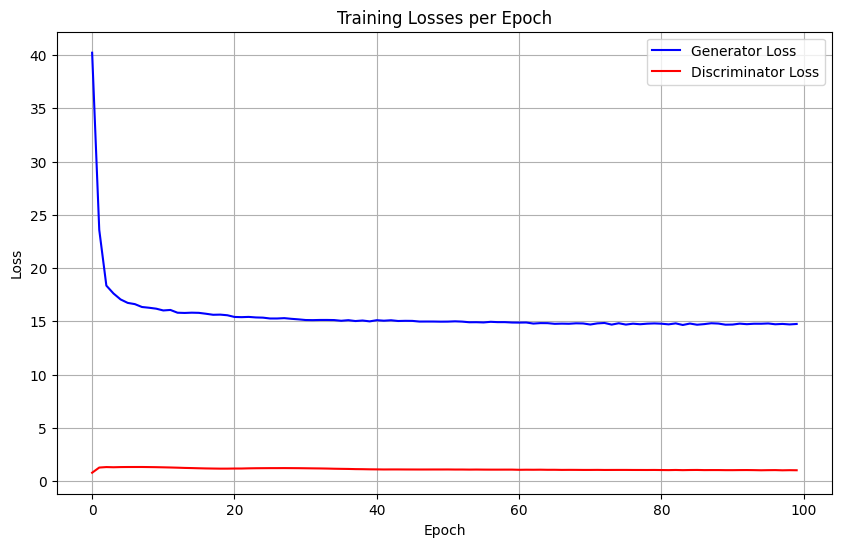

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['gen_loss'], label='Generator Loss', color='blue')
plt.plot(history['disc_loss'], label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses per Epoch')
plt.legend()
plt.grid(True)
plt.show()


Before changes: PSNR = 28.21 dB, SSIM = 0.2300
After changes: PSNR = 28.30 dB, SSIM = 0.3578


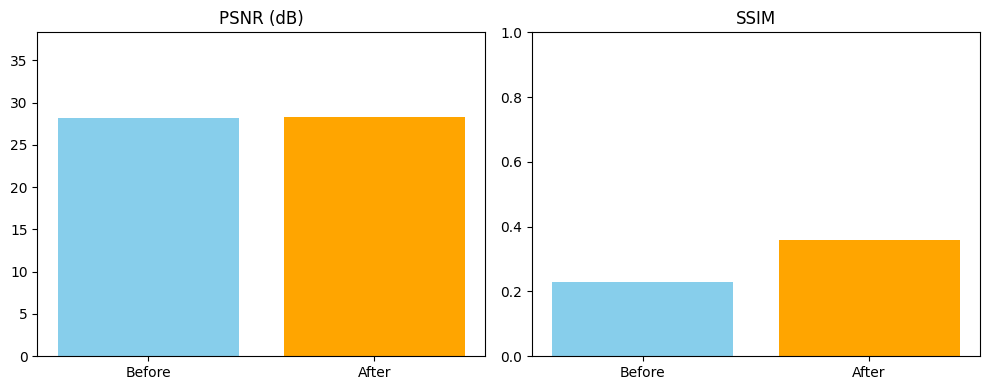

In [92]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from math import log10, sqrt

# Calculate PSNR
def calculate_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Read images (ensure both are same size and in grayscale or color as needed)
img1 = cv2.imread('/content/drive/MyDrive/Rainy_road_images/rainy_DL_0.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('/content/drive/MyDrive/my_model/output_file/dehazed_rainy_DL_100.jpg', cv2.IMREAD_COLOR)

# Calculate PSNR and SSIM (before change)
psnr_before = calculate_psnr(img1, img2)
ssim_before = ssim(img1, img2, channel_axis=2)

print(f"Before changes: PSNR = {psnr_before:.2f} dB, SSIM = {ssim_before:.4f}")

# Example change: apply Gaussian blur as a 'modification'
img2_modified = cv2.GaussianBlur(img2, (5, 5), 0)

# Calculate PSNR and SSIM (after change)
psnr_after = calculate_psnr(img1, img2_modified)
ssim_after = ssim(img1, img2_modified, channel_axis=2)

print(f"After changes: PSNR = {psnr_after:.2f} dB, SSIM = {ssim_after:.4f}")

# Plotting the results
labels = ['Before', 'After']
psnr_values = [psnr_before, psnr_after]
ssim_values = [ssim_before, ssim_after]

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(labels, psnr_values, color=['skyblue', 'orange'])
ax[0].set_title('PSNR (dB)')
ax[0].set_ylim(0, max(psnr_values) + 10)
ax[1].bar(labels, ssim_values, color=['skyblue', 'orange'])
ax[1].set_title('SSIM')
ax[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()
